# Train BlazePalm Model

In [1]:
import os
import glob
import json

import tensorflow as tf
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from utils import anchors_generator, encoder, loss_function
from nets import blaze_palm 
from utils.data_generator import DataGenerator

In [2]:
tf.__version__

'2.3.1'

## Create BlazePalm Model

In [3]:
model = blaze_palm.build_blaze_palm_model()

In [4]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
depthwise_conv2d (DepthwiseConv (None, 128, 128, 32) 320         activation[0][0]                 
_______________________________________________________________________________________

In [5]:
adam = tf.keras.optimizers.Adam()
ssd_loss = loss_function.SSDLoss(alpha=1./256.)
model.compile(optimizer='adam', loss=ssd_loss.compute_loss)

## Prepare Data

In [6]:
train_data_generator = DataGenerator(image_dir=os.path.join('dataset', 'image'), batch_size=32,
                                     annotation_dir=os.path.join('dataset', 'annotation'), num_anchors=896)
val_data_generator = DataGenerator(image_dir=os.path.join('dataset', 'image'), batch_size=32,
                                     annotation_dir=os.path.join('dataset', 'annotation'), num_anchors=896)

In [7]:
batch = train_data_generator.__getitem__(0)
ssd_loss.compute_loss(batch[1], model.predict(batch[0]))

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0.20150433, 0.02295622, 0.02331704, 0.02122912, 0.10993828,
       0.05107367, 0.02388302, 0.1129437 , 0.13601439, 0.02184814,
       0.09753842, 0.03956315, 0.08155803, 0.06163715, 0.03638192,
       0.05320627, 0.06882753, 0.0652829 , 0.09116548, 0.02209236,
       0.08254214, 0.0582512 , 0.11189399, 0.02305966, 0.02087699,
       0.04866564, 0.0349156 , 0.0353381 , 0.02028702, 0.02752994,
       0.02357368, 0.05757285], dtype=float32)>

## Training

> `fit_generator` not work

In [8]:
history = model.fit(x=train_data_generator, epochs=1000)

Epoch 1/1000
3/3 [==============================] - 1s 318ms/step - loss: 0.0591
Epoch 2/1000
3/3 [==============================] - 1s 416ms/step - loss: 0.0522
Epoch 3/1000
3/3 [==============================] - 1s 417ms/step - loss: 0.0506
Epoch 4/1000
3/3 [==============================] - 1s 461ms/step - loss: 0.0490
Epoch 5/1000
3/3 [==============================] - 1s 463ms/step - loss: 0.0488
Epoch 6/1000
3/3 [==============================] - 1s 472ms/step - loss: 0.0468
Epoch 7/1000
3/3 [==============================] - 1s 451ms/step - loss: 0.0448
Epoch 8/1000
3/3 [==============================] - 1s 475ms/step - loss: 0.0431
Epoch 9/1000
3/3 [==============================] - 1s 474ms/step - loss: 0.0439
Epoch 10/1000
3/3 [==============================] - 1s 475ms/step - loss: 0.0410
Epoch 11/1000
3/3 [==============================] - 1s 476ms/step - loss: 0.0409
Epoch 12/1000
3/3 [==============================] - 1s 475ms/step - loss: 0.0445
Epoch 13/1000
3/3 [======

3/3 [==============================] - 1s 484ms/step - loss: 0.0188
Epoch 99/1000
3/3 [==============================] - 1s 482ms/step - loss: 0.0216
Epoch 100/1000
3/3 [==============================] - 1s 416ms/step - loss: 0.0206
Epoch 101/1000
3/3 [==============================] - 1s 438ms/step - loss: 0.0201
Epoch 102/1000
3/3 [==============================] - 1s 485ms/step - loss: 0.0195
Epoch 103/1000
3/3 [==============================] - 1s 416ms/step - loss: 0.0219
Epoch 104/1000
3/3 [==============================] - 1s 458ms/step - loss: 0.0195
Epoch 105/1000
3/3 [==============================] - 1s 486ms/step - loss: 0.0197
Epoch 106/1000
3/3 [==============================] - 1s 483ms/step - loss: 0.0215
Epoch 107/1000
3/3 [==============================] - 1s 484ms/step - loss: 0.0199
Epoch 108/1000
3/3 [==============================] - 1s 433ms/step - loss: 0.0193
Epoch 109/1000
3/3 [==============================] - 1s 484ms/step - loss: 0.0218
Epoch 110/1000
3/3 [

3/3 [==============================] - 1s 462ms/step - loss: 0.0079
Epoch 197/1000
3/3 [==============================] - 1s 464ms/step - loss: 0.0089
Epoch 198/1000
3/3 [==============================] - 1s 440ms/step - loss: 0.0106
Epoch 199/1000
3/3 [==============================] - 1s 484ms/step - loss: 0.0082
Epoch 200/1000
3/3 [==============================] - 1s 485ms/step - loss: 0.0078
Epoch 201/1000
3/3 [==============================] - 1s 459ms/step - loss: 0.0107
Epoch 202/1000
3/3 [==============================] - 1s 419ms/step - loss: 0.0077
Epoch 203/1000
3/3 [==============================] - 1s 485ms/step - loss: 0.0076
Epoch 204/1000
3/3 [==============================] - 1s 432ms/step - loss: 0.0096
Epoch 205/1000
3/3 [==============================] - 1s 462ms/step - loss: 0.0079
Epoch 206/1000
3/3 [==============================] - 1s 486ms/step - loss: 0.0077
Epoch 207/1000
3/3 [==============================] - 1s 441ms/step - loss: 0.0092
Epoch 208/1000
3/3 

3/3 [==============================] - 1s 465ms/step - loss: 0.0014
Epoch 295/1000
3/3 [==============================] - 1s 440ms/step - loss: 0.0012
Epoch 296/1000
3/3 [==============================] - 1s 486ms/step - loss: 0.0015
Epoch 297/1000
3/3 [==============================] - 1s 418ms/step - loss: 0.0013
Epoch 298/1000
3/3 [==============================] - 1s 440ms/step - loss: 0.0012
Epoch 299/1000
3/3 [==============================] - 1s 464ms/step - loss: 0.0012
Epoch 300/1000
3/3 [==============================] - 1s 485ms/step - loss: 0.0017
Epoch 301/1000
3/3 [==============================] - 1s 485ms/step - loss: 0.0010
Epoch 302/1000
3/3 [==============================] - 1s 461ms/step - loss: 0.0012
Epoch 303/1000
3/3 [==============================] - 1s 487ms/step - loss: 0.0011
Epoch 304/1000
3/3 [==============================] - 1s 419ms/step - loss: 0.0010
Epoch 305/1000
3/3 [==============================] - 1s 486ms/step - loss: 8.2198e-04
Epoch 306/1000


3/3 [==============================] - 1s 488ms/step - loss: 8.0740e-04
Epoch 390/1000
3/3 [==============================] - 1s 440ms/step - loss: 5.0887e-04
Epoch 391/1000
3/3 [==============================] - 1s 443ms/step - loss: 4.7641e-04
Epoch 392/1000
3/3 [==============================] - 1s 490ms/step - loss: 4.0087e-04
Epoch 393/1000
3/3 [==============================] - 1s 488ms/step - loss: 3.4375e-04
Epoch 394/1000
3/3 [==============================] - 1s 420ms/step - loss: 2.9966e-04
Epoch 395/1000
3/3 [==============================] - 1s 491ms/step - loss: 3.4689e-04
Epoch 396/1000
3/3 [==============================] - 1s 464ms/step - loss: 2.6548e-04
Epoch 397/1000
3/3 [==============================] - 1s 489ms/step - loss: 2.4793e-04
Epoch 398/1000
3/3 [==============================] - 1s 488ms/step - loss: 4.2078e-04
Epoch 399/1000
3/3 [==============================] - 1s 487ms/step - loss: 2.5247e-04
Epoch 400/1000
3/3 [==============================] - 1s 4

3/3 [==============================] - 1s 430ms/step - loss: 3.6375e-04
Epoch 484/1000
3/3 [==============================] - 1s 445ms/step - loss: 6.2834e-04
Epoch 485/1000
3/3 [==============================] - 1s 465ms/step - loss: 4.5754e-04
Epoch 486/1000
3/3 [==============================] - 1s 490ms/step - loss: 3.9180e-04
Epoch 487/1000
3/3 [==============================] - 1s 463ms/step - loss: 4.8179e-04
Epoch 488/1000
3/3 [==============================] - 1s 490ms/step - loss: 4.4812e-04
Epoch 489/1000
3/3 [==============================] - 1s 487ms/step - loss: 4.7683e-04
Epoch 490/1000
3/3 [==============================] - 1s 487ms/step - loss: 3.7865e-04
Epoch 491/1000
3/3 [==============================] - 1s 468ms/step - loss: 3.8037e-04
Epoch 492/1000
3/3 [==============================] - 1s 490ms/step - loss: 3.4770e-04
Epoch 493/1000
3/3 [==============================] - 1s 488ms/step - loss: 2.7263e-04
Epoch 494/1000
3/3 [==============================] - 1s 4

3/3 [==============================] - 1s 452ms/step - loss: 3.5201e-04
Epoch 578/1000
3/3 [==============================] - 1s 488ms/step - loss: 3.6649e-04
Epoch 579/1000
3/3 [==============================] - 1s 487ms/step - loss: 3.4025e-04
Epoch 580/1000
3/3 [==============================] - 1s 490ms/step - loss: 3.8877e-04
Epoch 581/1000
3/3 [==============================] - 1s 466ms/step - loss: 3.6022e-04
Epoch 582/1000
3/3 [==============================] - 1s 490ms/step - loss: 3.0080e-04
Epoch 583/1000
3/3 [==============================] - 1s 489ms/step - loss: 5.1866e-04
Epoch 584/1000
3/3 [==============================] - 1s 445ms/step - loss: 3.3884e-04
Epoch 585/1000
3/3 [==============================] - 1s 488ms/step - loss: 3.5043e-04
Epoch 586/1000
3/3 [==============================] - 1s 488ms/step - loss: 4.1989e-04
Epoch 587/1000
3/3 [==============================] - 1s 473ms/step - loss: 2.6851e-04
Epoch 588/1000
3/3 [==============================] - 1s 4

3/3 [==============================] - 1s 420ms/step - loss: 3.5627e-04
Epoch 672/1000
3/3 [==============================] - 1s 444ms/step - loss: 5.1190e-04
Epoch 673/1000
3/3 [==============================] - 1s 489ms/step - loss: 3.5971e-04
Epoch 674/1000
3/3 [==============================] - 1s 420ms/step - loss: 5.7020e-04
Epoch 675/1000
3/3 [==============================] - 1s 420ms/step - loss: 5.1946e-04
Epoch 676/1000
3/3 [==============================] - 1s 489ms/step - loss: 5.2353e-04
Epoch 677/1000
3/3 [==============================] - 1s 487ms/step - loss: 5.5864e-04
Epoch 678/1000
3/3 [==============================] - 1s 475ms/step - loss: 5.5471e-04
Epoch 679/1000
3/3 [==============================] - 1s 450ms/step - loss: 4.9075e-04
Epoch 680/1000
3/3 [==============================] - 1s 490ms/step - loss: 3.7689e-04
Epoch 681/1000
3/3 [==============================] - 1s 485ms/step - loss: 3.6358e-04
Epoch 682/1000
3/3 [==============================] - 1s 4

3/3 [==============================] - 1s 422ms/step - loss: 1.2169e-04
Epoch 766/1000
3/3 [==============================] - 1s 443ms/step - loss: 1.1202e-04
Epoch 767/1000
3/3 [==============================] - 1s 467ms/step - loss: 9.0320e-05
Epoch 768/1000
3/3 [==============================] - 1s 467ms/step - loss: 1.1014e-04
Epoch 769/1000
3/3 [==============================] - 1s 490ms/step - loss: 1.1790e-04
Epoch 770/1000
3/3 [==============================] - 1s 487ms/step - loss: 2.7296e-04
Epoch 771/1000
3/3 [==============================] - 1s 490ms/step - loss: 9.5014e-05
Epoch 772/1000
3/3 [==============================] - 1s 490ms/step - loss: 9.1420e-05
Epoch 773/1000
3/3 [==============================] - 1s 420ms/step - loss: 2.7590e-04
Epoch 774/1000
3/3 [==============================] - 1s 466ms/step - loss: 8.3907e-05
Epoch 775/1000
3/3 [==============================] - 1s 492ms/step - loss: 9.9888e-05
Epoch 776/1000
3/3 [==============================] - 1s 4

3/3 [==============================] - 1s 421ms/step - loss: 1.4800e-04
Epoch 860/1000
3/3 [==============================] - 1s 490ms/step - loss: 1.7580e-04
Epoch 861/1000
3/3 [==============================] - 1s 488ms/step - loss: 1.9102e-04
Epoch 862/1000
3/3 [==============================] - 1s 465ms/step - loss: 2.0895e-04
Epoch 863/1000
3/3 [==============================] - 1s 450ms/step - loss: 3.6017e-04
Epoch 864/1000
3/3 [==============================] - 1s 490ms/step - loss: 1.6302e-04
Epoch 865/1000
3/3 [==============================] - 1s 490ms/step - loss: 1.6610e-04
Epoch 866/1000
3/3 [==============================] - 1s 452ms/step - loss: 1.7277e-04
Epoch 867/1000
3/3 [==============================] - 1s 420ms/step - loss: 1.9905e-04
Epoch 868/1000
3/3 [==============================] - 1s 442ms/step - loss: 1.4904e-04
Epoch 869/1000
3/3 [==============================] - 1s 491ms/step - loss: 1.7700e-04
Epoch 870/1000
3/3 [==============================] - 1s 4

3/3 [==============================] - 1s 488ms/step - loss: 4.1018e-04
Epoch 954/1000
3/3 [==============================] - 1s 490ms/step - loss: 2.1974e-04
Epoch 955/1000
3/3 [==============================] - 1s 476ms/step - loss: 1.8439e-04
Epoch 956/1000
3/3 [==============================] - 1s 489ms/step - loss: 1.6885e-04
Epoch 957/1000
3/3 [==============================] - 1s 441ms/step - loss: 1.3387e-04
Epoch 958/1000
3/3 [==============================] - 1s 490ms/step - loss: 1.2995e-04
Epoch 959/1000
3/3 [==============================] - 1s 445ms/step - loss: 1.1092e-04
Epoch 960/1000
3/3 [==============================] - 1s 489ms/step - loss: 2.8792e-04
Epoch 961/1000
3/3 [==============================] - 1s 440ms/step - loss: 1.0149e-04
Epoch 962/1000
3/3 [==============================] - 1s 486ms/step - loss: 9.2161e-05
Epoch 963/1000
3/3 [==============================] - 1s 489ms/step - loss: 8.3018e-05
Epoch 964/1000
3/3 [==============================] - 1s 4

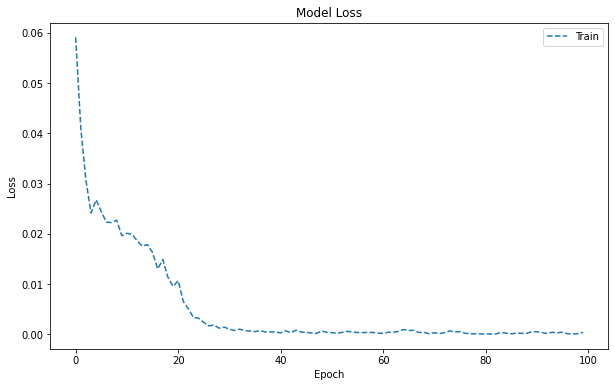

In [9]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'][::10], ls='--')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'])
plt.show()

## Test Model

In [10]:
from utils.anchor_config import AnchorsConfig
from utils.anchors_generator import AnchorsGenerator
from utils.encoder import center_to_corner

In [11]:
def sigmoid(values):
    return 1/(1+np.exp(-values))

In [12]:
def non_max_suppression_fast(boxes, probabilities=None, overlap_threshold=0.3):
    """
    Algorithm to filter bounding box proposals by removing the ones with a too low confidence score
    and with too much overlap.
    Source: https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    :param boxes: List of proposed bounding boxes
    :param overlap_threshold: the maximum overlap that is allowed
    :return: filtered boxes
    """
    # if there are no boxes, return an empty list
    if boxes.shape[1] == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0] - (boxes[:, 2] / [2])  # center x - width/2
    y1 = boxes[:, 1] - (boxes[:, 3] / [2])  # center y - height/2
    x2 = boxes[:, 0] + (boxes[:, 2] / [2])  # center x + width/2
    y2 = boxes[:, 1] + (boxes[:, 3] / [2])  # center y + height/2

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = boxes[:, 2] * boxes[:, 3]  # width * height
    idxs = y2


    # if probabilities are provided, sort on them instead
    if probabilities is not None:
        idxs = probabilities

    # sort the indexes
    idxs = np.argsort(idxs)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
                                               np.where(overlap > overlap_threshold)[0])))
    # return only the bounding boxes that were picked
    return pick

In [13]:
def preprocess(bgr_image, w, h, normailze=True):
    # convert to rgb
    rgb_image = bgr_image[:, :, ::-1]
    # pad to square and resize
    shape = np.r_[rgb_image.shape]
    padding = (shape.max() - shape[:2]).astype('uint32') // 2
    rgb_image = np.pad(rgb_image, ((padding[0], padding[0]), (padding[1], padding[1]), (0, 0)), mode='constant')
    rgb_image = cv2.resize(rgb_image, (w, h))
    rgb_image = np.ascontiguousarray(rgb_image)
    # normalize
    if normailze:
        rgb_image = np.ascontiguousarray(2 * ((rgb_image / 255) - 0.5).astype('float32'))
    # reshape as input shape
    rgb_image = rgb_image[tf.newaxis, ...]
    return rgb_image

In [14]:
anchor_config = AnchorsConfig(fixed_anchor_size=False)
anchor_generator = AnchorsGenerator(anchor_config)
anchors = anchor_generator.generate()
anchors_normalized = np.array([[anchor.x_center,anchor.y_center, anchor.w, anchor.h] for anchor in anchors])

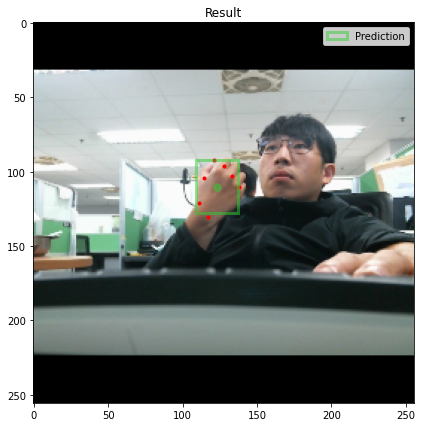

In [15]:
image_path = np.random.choice(glob.glob(os.path.join('dataset','image','*.jpg')))
image = preprocess(cv2.imread(image_path), 256, 256)
pred = model.predict(image)

output_clf = pred[:,:,0][0]
output_reg = pred[:,:,1:][0]
scores = sigmoid(output_clf)
t = 0.95
output_reg = output_reg[scores>t]
output_clf = output_clf[scores>t]
candidate_anchors = anchors_normalized[scores>t]

moved_output_reg = output_reg.copy()
moved_output_reg[:, :2] = moved_output_reg[:, :2] + candidate_anchors[:, :2] * 256

box_ids = non_max_suppression_fast(moved_output_reg[:, :4], output_clf)

center_wo_offst = candidate_anchors[box_ids,:2] * 256
bboxes = moved_output_reg[box_ids, :4].astype('int')
keypoints_set = output_reg[box_ids,4:].reshape(-1, 7, 2)
for i in range(len(keypoints_set)):
    keypoints_set[i] = keypoints_set[i] + center_wo_offst[i]

color = ['limegreen', 'r']
width = [3, 3]
style = ['-', '--']
alpha = [1, 0.5]


plt.figure(figsize=(7, 7))
plt.title("Result")
image_show = preprocess(cv2.imread(image_path), 256, 256, False)
result_image = image_show.copy()[0]
    
for i in range(len(bboxes)):
    cx, cy, w, h = bboxes[i][:4]
    x1, y1, x2, y2 = (cx-w//2, cy-h//2, cx+w//2, cy+h//2)
    if i == 0:
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, lw=width[1], ec=color[0], ls=style[0], alpha=alpha[1], facecolor="none", label='Prediction')
    else:
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, lw=width[1], ec=color[0], ls=style[0], alpha=alpha[1], facecolor="none")
    plt.gca().add_patch(rect)
    plt.scatter((x2+x1)/2, (y2+y1)/2, color=color[0], s=54.87, alpha=alpha[1])
    for key_point in keypoints_set[i]:
        plt.scatter(key_point[0], key_point[1], color=color[1], s=9.487)

plt.legend()
plt.imshow(result_image)
plt.show()

## Test Model

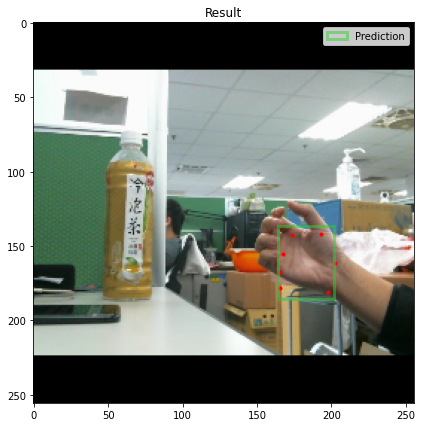

In [16]:
image_path = np.random.choice(glob.glob(os.path.join('dataset','image','*.jpg')))
image = preprocess(cv2.imread(image_path), 256, 256)
image_show = preprocess(cv2.imread(image_path), 256, 256, False)
# plt.imshow(image[0])

pred = model.predict(image)

pred_id = np.argmax(pred[0,:,0])
pred_loc = pred[0,:,1:][pred_id]
pred_loc[:2] = anchors_normalized[pred_id,:2]*256 + pred_loc[:2]
pred_loc[:4] = center_to_corner(np.array([pred_loc[:4]]))
pred_loc[4:] = (pred_loc[4:].reshape(-1, 2) + anchors_normalized[pred_id,:2]*256).reshape(-1)

color = ['limegreen', 'r']
width = [3, 3]
style = ['-', '--']
alpha = [1, 0.5]


plt.figure(figsize=(7, 7))
plt.title("Result")
result_image = image_show.copy()[0]    

x1, y1, x2, y2 = pred_loc[:4]
rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, 
                         lw=width[1], ec=color[0],
                         ls=style[0], alpha=alpha[1], facecolor="none", label='Prediction')
plt.gca().add_patch(rect)
for key_point in pred_loc[4:].reshape(-1, 2):
    plt.scatter(key_point[0], key_point[1], color=color[1], s=9.487)

# plt.scatter((x2+x1)/2, (y2+y1)/2, color=color[0], alpha=alpha[1], s=87)

plt.legend()
plt.imshow(result_image)
plt.show()

## Save Model

In [18]:
model_name = 'balzepalm_up16.h5'
model.save(model_name)

In [19]:
palm_model = tf.keras.models.load_model(model_name, 
                                        custom_objects={'compute_loss': loss_function.SSDLoss(alpha=1./256.).compute_loss})

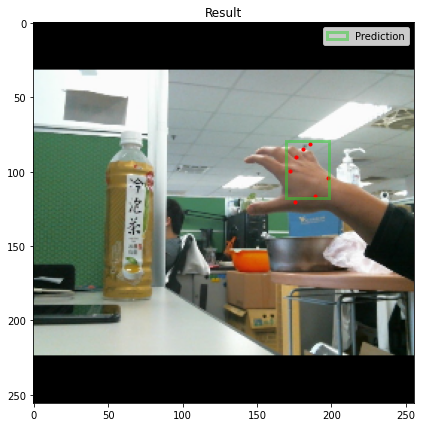

In [27]:
image_path = np.random.choice(glob.glob(os.path.join('dataset','image','*.jpg')))
image = preprocess(cv2.imread(image_path), 256, 256)
image_show = preprocess(cv2.imread(image_path), 256, 256, False)
# plt.imshow(image[0])

pred = palm_model.predict(image)

pred_id = np.argmax(pred[0,:,0])
pred_loc = pred[0,:,1:][pred_id]
pred_loc[:2] = anchors_normalized[pred_id,:2]*256 + pred_loc[:2]
pred_loc[:4] = center_to_corner(np.array([pred_loc[:4]]))
pred_loc[4:] = (pred_loc[4:].reshape(-1, 2) + anchors_normalized[pred_id,:2]*256).reshape(-1)

color = ['limegreen', 'r']
width = [3, 3]
style = ['-', '--']
alpha = [1, 0.5]


plt.figure(figsize=(7, 7))
plt.title("Result")
result_image = image_show.copy()[0]    

x1, y1, x2, y2 = pred_loc[:4]
rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, 
                         lw=width[1], ec=color[0],
                         ls=style[0], alpha=alpha[1], facecolor="none", label='Prediction')
plt.gca().add_patch(rect)
for key_point in pred_loc[4:].reshape(-1, 2):
    plt.scatter(key_point[0], key_point[1], color=color[1], s=9.487)

# plt.scatter((x2+x1)/2, (y2+y1)/2, color=color[0], alpha=alpha[1], s=87)

plt.legend()
plt.imshow(result_image)
plt.show()

## Saved as TFLite Model

In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(palm_model)

In [29]:
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpf4ltm3ev/assets


In [34]:
import pathlib

In [35]:
tflite_models_dir = pathlib.Path("./")
tflite_model_file = tflite_models_dir/model_name.replace('.h5', '.tflite')
tflite_model_file.write_bytes(tflite_model)

6506940